## Chapter 8: Tree-Based Methods - Lab

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (
    DecisionTreeClassifier as DTC,
    DecisionTreeRegressor as DTR,
    plot_tree,
    export_text
)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (
    RandomForestRegressor as RF,
    GradientBoostingRegressor as GBR
)
from ISLP.bart import BART

### Fitting Classification Trees

We use classification trees to analyze the Carseats data set. In these data, `Sales` is a continuous variable, and so we begin by recoding it as a binary variable. We use the `where()` function to create a variable, called `High`, which takes on a value of Yes if the Sales variable exceeds 8, and takes on a value of No otherwise.

In [4]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8, "Yes", "No")

We now use `DecisionTreeClassifier()` to fit a classification tree in order to predict `High` using all variables but `Sales`.

In [6]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

We need to define:

- `max_depth` - how deep to grow the tree
- `min_samples_split` - the minimum number of observations in a node to be eligible for splitting
- `criterion` - whether to use Gini or cross-entropy as the split criterion

We also set a `random_state` for reproducibility

In [15]:
clf = DTC(
    criterion='entropy',
    max_depth=3,
    random_state=0
)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [16]:
accuracy_score(High, clf.predict(X))

0.79

The training error rate is 21%.

We can access the deviance using `log_loss`. A small deviance indicates that the tree provides a good fit for the training data.

In [17]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev

0.4710647062649358

We can use the `plot()` function to display the tree structure:

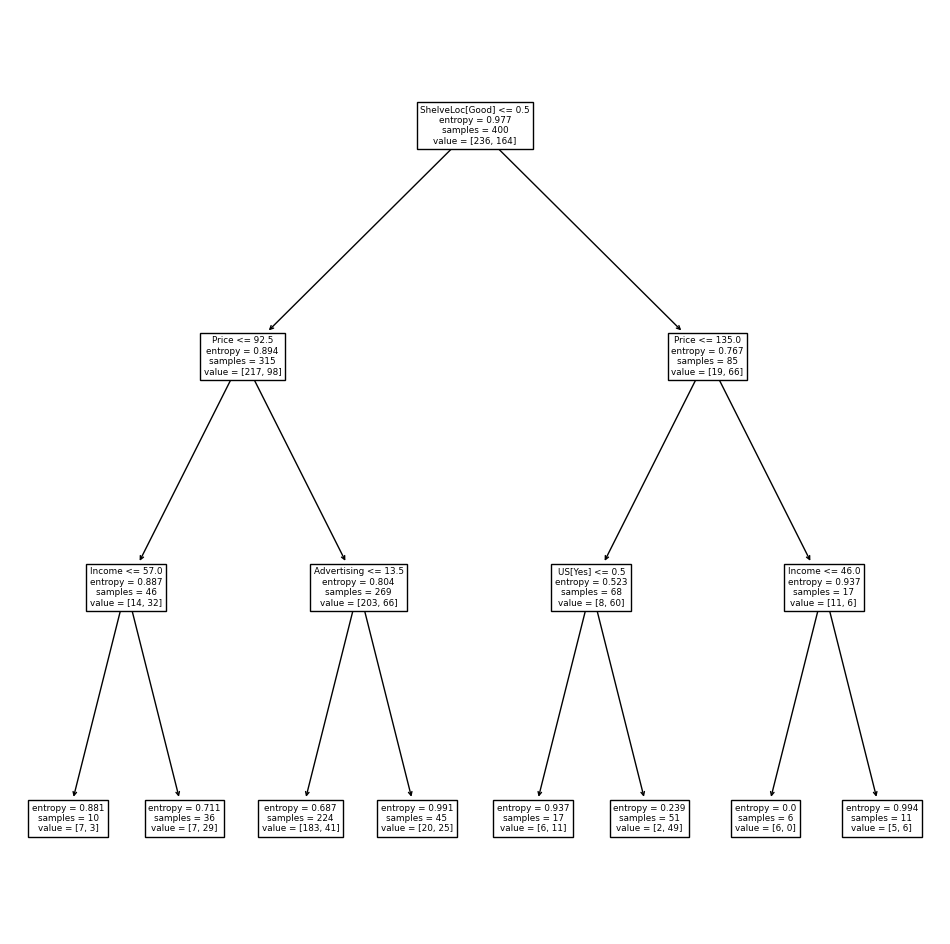

In [18]:
ax = subplots(figsize=(12,12))[1]
plot_tree(
    clf,
    feature_names=feature_names,
    ax=ax
);

We can see the number of observations in each leaf node that take on the values `Yes` and `No` by calling `export_text`, specify `show_weights=True`.

In [20]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



We need to estimate the test error. We split the observations into a training set and a test set, build the tree using the training set, and evaluate its performance on the test data.

In [21]:
validation = skm.ShuffleSplit(
    n_splits=1,
    test_size=200,
    random_state=0
)

results = skm.cross_validate(
    clf, 
    D,
    High,
    cv=validation
)

results['test_score']

array([0.685])

This approach leads to correct predictions for 68.5% of the test dataset.

Would pruning the tree lead to improved performance? We split the data into a training and test set. We use cross-validation to prune the tree on the training set, and then evaluate performance of the pruned tree on the test set.

In [22]:
(X_train,
X_test,
High_train,
High_test) = skm.train_test_split(
    X,
    High,
    test_size=0.5,
    random_state=0
)

We refit the full tree on the training data set, without settin a `max_depth` (since we learn this through cross-validation):

In [24]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

We use the `cost_complexity_pruning_path()` method of `clf` to extract cost-complexity values:

In [25]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10, random_state=1, shuffle=True)

In [26]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

0.685

Taking a look at the pruned tree:

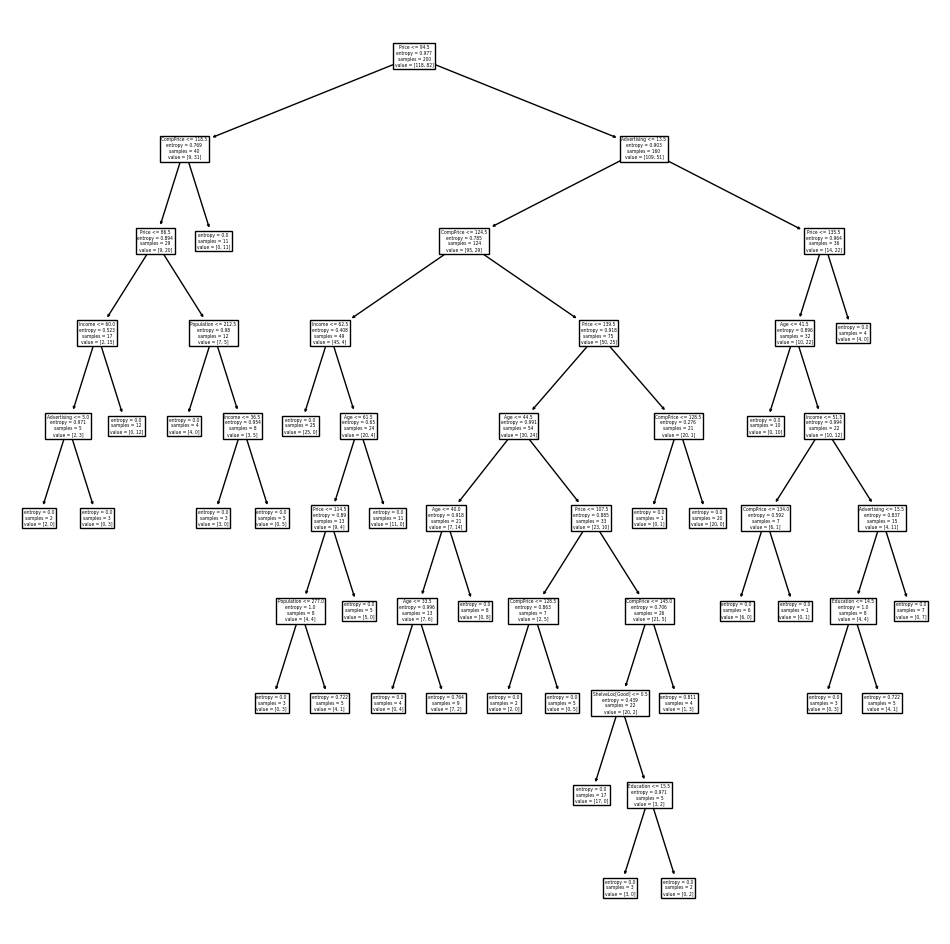

In [27]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(
    best_,
    feature_names=feature_names,
    ax=ax
);

In [28]:
best_.tree_.n_leaves

30

The tree with 30 terminal nodes results in the lowest cross-validation error rate with an accuracy of 68.5%. 

How well does this pruned tree perform on the test dataset?

In [29]:
print(accuracy_score(High_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


The pruned tree correctly classifies about 72% of the test observations correctly, which is not much of an improvement in performance.

### Fitting Regression Trees

Here we fit a regression tree to the `Boston` dataset. The goal is to predict the `medv` of a house using the other variables.

In [30]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [31]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(
     X,                           
     Boston['medv'],
     test_size=0.3,
     random_state=0
)

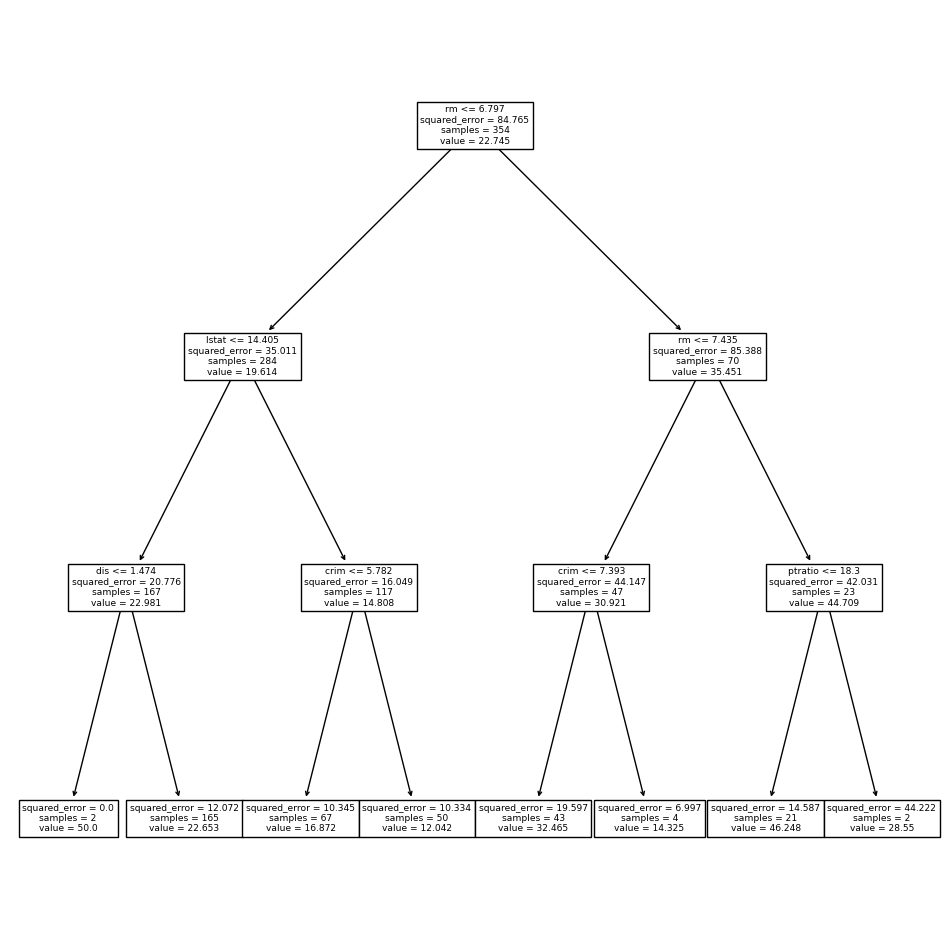

In [32]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(
    reg,
    feature_names=feature_names,
    ax=ax
);

The tree predicts a median house price of $12,042 for small-sized homes (`rm < 6.8`), in suburbs in which residents have low socioeconomic status (`lstat > 14.4`) and the crime-rate is moderate (`crim > 5.8`).

We use the cross-validation function to see whether pruning the tree will improve performance:

In [33]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(
    5,
    shuffle=True,
    random_state=10
)
grid = skm.GridSearchCV(
    reg,
    {'ccp_alpha': ccp_path.ccp_alphas},
    refit=True,
    cv=kfold,
    scoring='neg_mean_squared_error'
)
G = grid.fit(X_train, y_train)

We use the pruned tree to make predictions on the test set:

In [34]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.069857549754044

The test set MSE associated with the regression tree is 28.07. The square root of the MSE is therefore around 5.30, indicating that this model leads to test predictions that are within around $5300 of the true median home value for the suburb.

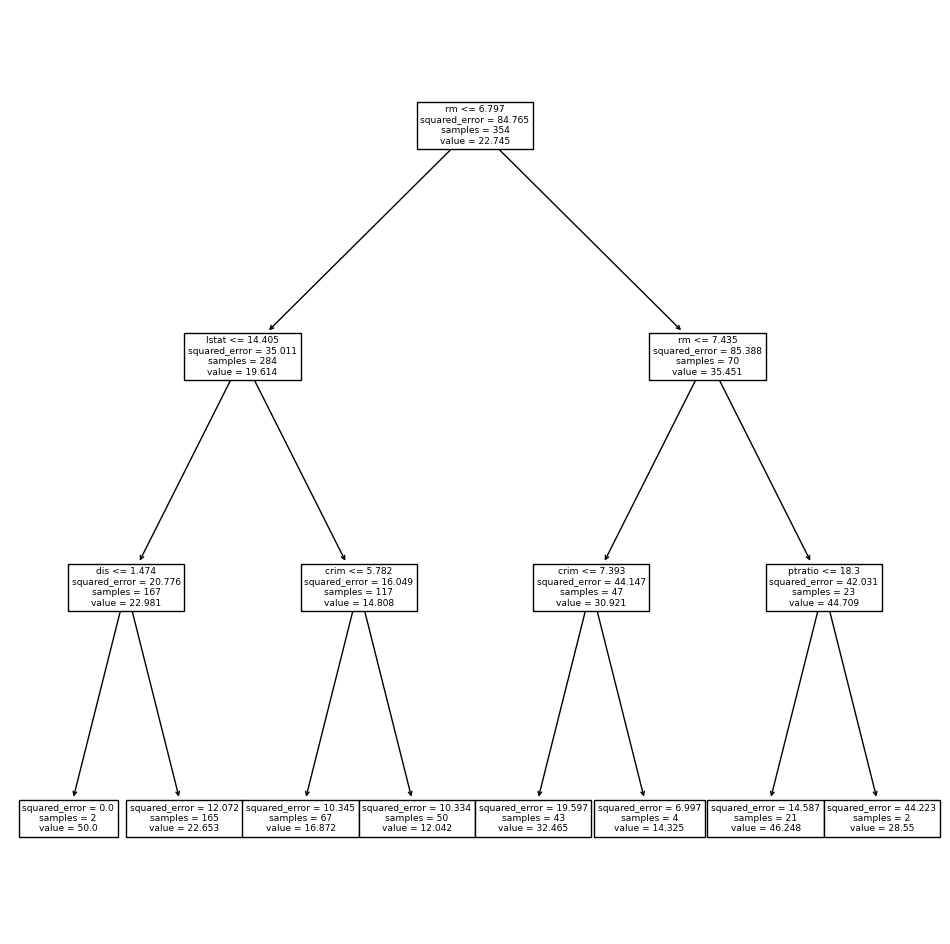

In [35]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
feature_names=feature_names,
ax=ax);

### Bagging and Random Forests

We apply bagging and random forests to the `Boston` data using the `RandomForestRegressor()` from the `sklearn.ensemble` package. Because bagging is just a special case of random forest where m = p, we can use `RandomForestRegressor()`.

In [36]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

How well does this bagged model perform on the test set?

14.634700151315787

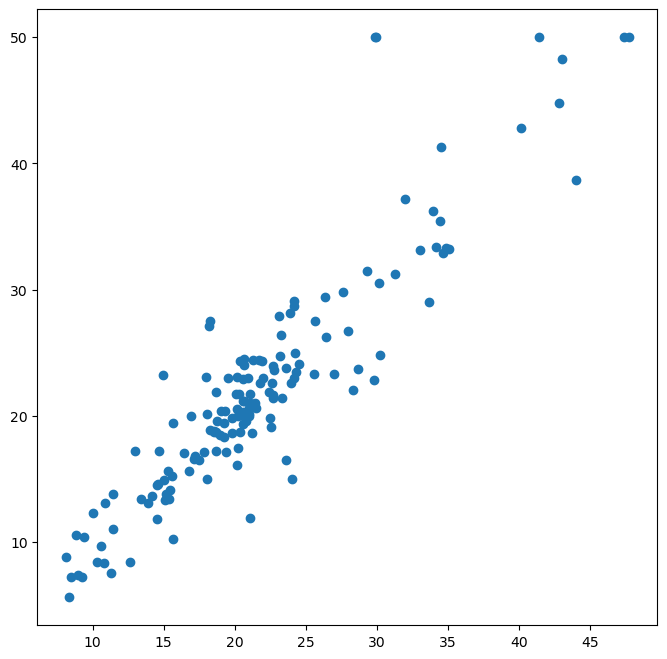

In [37]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

The test set MSE with the bagged regression tree is 14.63, about half of that obtained using an optimally-pruned single tree.

Growing a random forest follows a similar procedure, except we use a smaller value of the `max_features` argument. By default, `RandomForestRegressor()` uses _p_ variables when building a random forest of regression trees (i.e. defaults to bagging) and _√p_ variables when building a random forest of classification trees. Here, we set `max_features=6`.

In [38]:
RF_boston = RF(max_features=6,
random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

20.04276446710527

The MSE of 20.04 tells us that random forests do worse than bagging in this case.

We can get the importance of each feature by extracting the `feature_importances_` from the model:

In [39]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names
)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


### Boosting

We use `GradientBoostingRegressor()` from `sklearn.ensemble` to fit boosted regression trees to the `Bosto` dataset. For classification we would use `GradientBoostingClassifier()`. The argument `n_estimators=5000` indicates that we want 5000 trees, and the option `max_depth=3` limits the depth
of each tree. The argument `learning_rate` is the λ from the boosting algorithm.

In [40]:
boost_boston = GBR(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=3,
    random_state=0
)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

To get an idea for how the training error decreases we can use the `staged_predict()` method to get the predicted values along the path:

In [42]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)

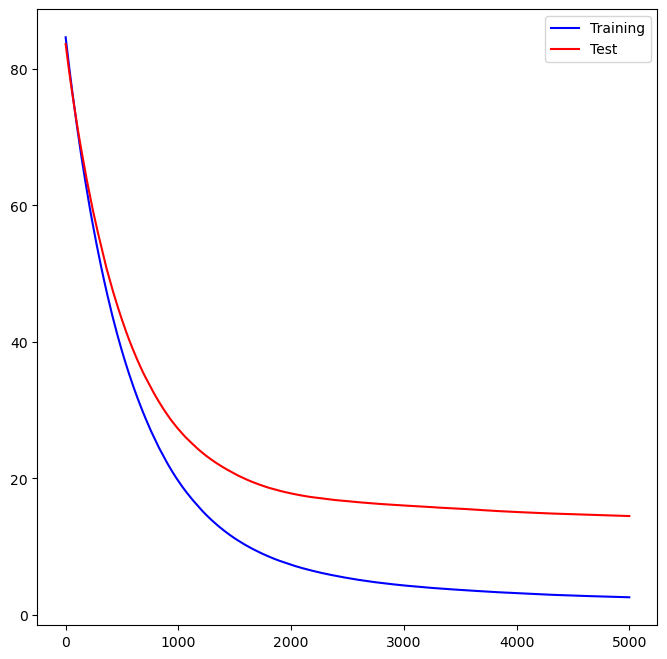

In [43]:
plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(
    plot_idx,
    boost_boston.train_score_,
    'b',
    label='Training'
)
ax.plot(
    plot_idx,
    test_error,
    'r',
    label='Test'
)
ax.legend();

We now use the boosted model to predict `medv` on the test set:

In [44]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.481405918831591

The test MSE obtained is 14.48, similar to the test MSE for bagging.

### Bayesian Additive Regression Trees

We use an implementation of BART from the `ISLP.bart` package. We fit a model to the `Boston` housing dataset. This `BART()` estimator is designed for quantitative outcome variables.

In [47]:
bart_boston = BART(
    random_state=0,
    burnin=5,
    ndraw=15
)
bart_boston.fit(X_train, y_train)

ValueError: high is out of bounds for int32